<a href="https://colab.research.google.com/github/rafaeloliveiralopes/image_based_recommendation_system/blob/main/image_based_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import normalize
import faiss
from tqdm import tqdm

In [6]:
# Carrega o modelo pré-treinado (ResNet50 sem a camada superior)
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
print("Modelo carregado.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Modelo carregado.


In [7]:
# 2. Função para extrair características de uma imagem
def extract_features(img_path, model):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

In [12]:
#hide-output
# Dowload  images do site kaggle
!rm -rf fashion-product-images-small.zip fashion-product-images-small myntradataset images


In [ ]:
# 3. Carrega e processa o conjunto de dados (exemplo com diretório de imagens)
dataset_path = "/content/myntradataset/images/"
image_paths = []

# Coletar caminhos de todas as imagens
for root, _, files in os.walk(dataset_path):
    for file in tqdm(files, desc="Processando imagens"):
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            image_paths.append(os.path.join(root, file))

print(f"Total de imagens carregadas: {len(image_paths)}")

Processando imagens: 100%|██████████| 44441/44441 [00:00<00:00, 738652.92it/s]

Total de imagens carregadas: 44441


In [ ]:
# 4. Extrair características para todas as imagens
features_list = []
for path in image_paths:
    features = extract_features(path, model)
    features_list.append(features)

features_db = np.array(features_list)
features_db = normalize(features_db)  # Normalizar para similaridade cosseno

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━

In [ ]:
# 5. Criar índice FAISS para busca rápida
dimension = features_db.shape[1]
index = faiss.IndexFlatIP(dimension)  # Produto Interno (equivalente a similaridade cosseno)
faiss.normalize_L2(features_db)       # Normalizar para o índice
index.add(features_db)

In [ ]:
# 6. Função de recomendação
def recommend_similar_images(query_path, top_k=5):
    # Extrair características da imagem de consulta
    query_features = extract_features(query_path, model)
    query_features = normalize([query_features])

    # Buscar similares
    distances, indices = index.search(query_features, top_k)

    # Exibir resultados
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(load_img(query_path))
    plt.title("Consulta")
    plt.axis('off')

    for i, idx in enumerate(indices[0]):
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(load_img(image_paths[idx]))
        plt.title(f"Similar {i+1}")
        plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


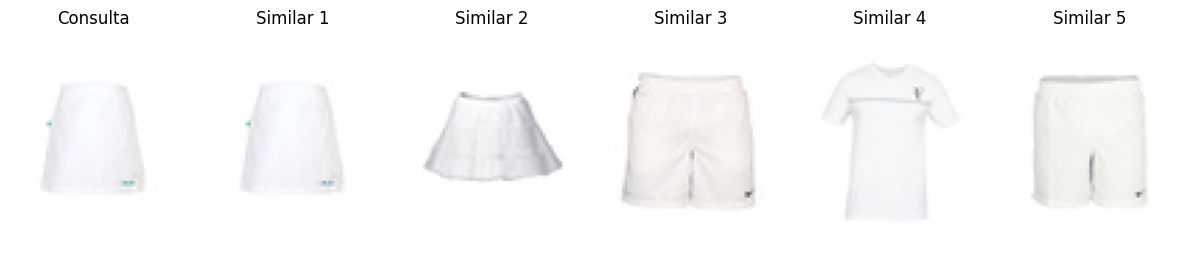

In [ ]:
# 7. Testar com uma imagem de exemplo
query_image_path = "/content/images/10000.jpg";
recommend_similar_images(query_image_path)